In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
from dateutil.parser import parse
from itertools import chain
import operator
import sys
from fbprophet import Prophet


In [2]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [3]:
dfsnp500 = pd.read_csv("resources/snp500.csv")
dfsnp500.head()

,Date,open,high,low,close,adjclose,volume,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,1/3/2000,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/4/2000,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/5/2000,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/6/2000,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/7/2000,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dfsnp500_clean = dfsnp500.loc[:,['Date','open','high','low','close','adjclose','volume']]

#dfsnp500['DateN'] = dfsnp500['Date'].apply(datetime.strptime('Date', '%Y-%m-%d'))

dfsnp500_clean['clean_date'] = pd.to_datetime(dfsnp500_clean['Date'])
dfsnp500_clean.set_index('clean_date',inplace=True)

In [5]:
dfsnp500_clean.head()

,Date,open,high,low,close,adjclose,volume
clean_date,,,,,,,
2000-01-03,1/3/2000,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1/4/2000,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1/5/2000,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1/6/2000,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1/7/2000,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [6]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [7]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


In [8]:
btc_usd_price_kraken.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [9]:
# Chart the BTC pricing data
btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
py.iplot([btc_trace])

In [10]:
# Pull pricing data for 3 more BTC exchanges
# ADD YALE/SPCOMP
exchanges = ['COINBASE','BITSTAMP','ITBIT']


exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    if exchange == 'SPCOMP':
        exchange_code = 'YALE/{}'.format(exchange)
    else:    
        exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [11]:
exchange_data

{'BITSTAMP':                 Open      High       Low     Close  Volume (BTC)  \
 Date                                                               
 2011-09-13      5.80      6.00      5.65      5.97     58.371382   
 2011-09-14      5.58      5.72      5.52      5.53     61.145984   
 2011-09-15      5.12      5.24      5.00      5.13     80.140795   
 2011-09-16      4.82      4.87      4.80      4.85     39.914007   
 2011-09-17      4.87      4.87      4.87      4.87      0.300000   
 2011-09-18      4.87      4.92      4.81      4.92    119.812800   
 2011-09-19      4.90      4.90      4.90      4.90     20.000000   
 2011-09-20      4.92      5.66      4.92      5.66     89.280711   
 2011-09-21      5.70      5.79      5.66      5.66     17.629322   
 2011-09-22      5.68      5.72      5.68      5.72     43.778422   
 2011-09-23      5.70      5.72      5.70      5.72     20.680037   
 2011-09-24      5.70      5.76      5.68      5.68     90.587066   
 2011-09-25      6.05 

In [12]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [13]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [155]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

In [156]:
btc_usd_datasets.tail()

,BITSTAMP,COINBASE,ITBIT,KRAKEN,S&P 500
2018-01-13,14233.654008,14202.494478,14256.959157,14443.863557,NaN
2018-01-14,13544.440953,13633.659200,13619.433483,13742.376128,NaN
2018-01-15,13875.586308,13831.601515,13850.189661,13889.047827,NaN
2018-01-16,11800.132584,11738.709333,11898.419508,11784.994745,NaN
2018-01-17,10459.667942,10513.544365,NaN,10525.626956,NaN


In [171]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [172]:
# Plot all of the BTC exchange prices
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [173]:
#Pull Stock Market Data
#YALE/SPCOMP

In [174]:
# Yale S&P data
yale_usd_s7p = get_quandl_data('YALE/SPCOMP')

Loaded YALE/SPCOMP from cache


In [175]:
dfsnp500_clean.head()

,Date,open,high,low,close,Weighted Price,volume
clean_date,,,,,,,
2000-01-03,1/3/2000,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1/4/2000,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1/5/2000,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1/6/2000,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1/7/2000,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [176]:
yale_usd_s7p_price = yale_usd_s7p['S&P Composite']

In [177]:
yale_usd_s7p.columns

Index(['S&P Composite', 'Dividend', 'Earnings', 'CPI', 'Long Interest Rate',
       'Real Price', 'Real Dividend', 'Real Earnings',
       'Cyclically Adjusted PE Ratio'],
      dtype='object')

In [178]:
yale_usd_s7p = yale_usd_s7p.rename(columns={'S&P Composite': 'Weighted Price' })

In [179]:
yale_usd_s7p['20171001':'20171215']

,Weighted Price,Dividend,Earnings,CPI,Long Interest Rate,Real Price,Real Dividend,Real Earnings,Cyclically Adjusted PE Ratio
Year,,,,,,,,,
2017-10-31,2557.00,48.423333,NaN,246.663,2.36,2557.108847,48.425395,NaN,31.150018
2017-11-30,2593.61,48.676667,NaN,246.669,2.35,2593.657315,48.677555,NaN,31.614559


In [180]:
dfsnp500_clean = dfsnp500_clean.rename(columns={'adjclose': 'Weighted Price' })
dfsnp500_clean.head()

,Date,open,high,low,close,Weighted Price,volume
clean_date,,,,,,,
2000-01-03,1/3/2000,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1/4/2000,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1/5/2000,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1/6/2000,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1/7/2000,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [181]:
exchange_data['S&P 500'] = dfsnp500_clean['20120101':'20180115']

In [182]:
yale_usd_s7p['20171129':'20171201']

,Weighted Price,Dividend,Earnings,CPI,Long Interest Rate,Real Price,Real Dividend,Real Earnings,Cyclically Adjusted PE Ratio
Year,,,,,,,,,
2017-11-30,2593.61,48.676667,NaN,246.669,2.35,2593.657315,48.677555,NaN,31.614559


In [183]:
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [184]:
btc_usd_datasets.head()

,BITSTAMP,COINBASE,ITBIT,KRAKEN,S&P 500
2011-09-13,5.929231,NaN,NaN,NaN,NaN
2011-09-14,5.590798,NaN,NaN,NaN,NaN
2011-09-15,5.094272,NaN,NaN,NaN,NaN
2011-09-16,4.854515,NaN,NaN,NaN,NaN
2011-09-17,4.870000,NaN,NaN,NaN,NaN


In [185]:
# Plot all of the BTC exchange prices
df_scatter(btc_usd_datasets['20170101':'20171230'], 'Bitcoin Price (USD) By Exchange Vs S&P Composite')

In [186]:
exchange_data['BITSTAMP']['20171229':'20171230']

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-12-29,14436.99,15111.00,13998.0,14340.0,13505.702992,1.957276e+08,14492.221462
2017-12-30,14351.00,14463.28,12050.0,12640.0,21749.674446,2.859856e+08,13148.957748


In [187]:
#'COINBASE','BITSTAMP','ITBIT'
exchange_data['COINBASE']['20171229':'20171230']

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-12-29,14450.01,15105.34,14041.81,14565.05,18227.243930,2.662440e+08,14606.928206
2017-12-30,14565.04,14639.79,12500.00,12839.99,28471.496381,3.834518e+08,13467.917959


In [188]:
#'ITBIT'
exchange_data['ITBIT']['20171229':'20171230']

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-12-29,14468.48,15063.26,14012.57,14486.91,2530.906,3.676066e+07,14524.703680
2017-12-30,14485.60,14551.98,12382.16,12676.36,2398.585,3.234562e+07,13485.293182


In [195]:
#Start Regression
reg_data = exchange_data['KRAKEN']['20160404':'20180112'].loc[:,['Open','High', 'Low', 'Close', 'Volume (BTC)' , 'Volume (Currency)', 'Weighted Price']]

In [196]:
from statsmodels.tsa.arima_model import ARIMA

In [197]:
# define a new feature, HL_PCT
#reg_data = reg_data['20160101':'20180112'][['Close']]
reg_data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2016-04-04,421.48,421.600,417.542,420.990,582.497009,244552.127940,419.834135
2016-04-05,419.51,424.970,419.500,422.760,985.017478,416690.188335,423.028218
2016-04-06,423.00,424.611,421.560,423.550,891.882500,377349.566170,423.093363
2016-04-07,423.54,424.390,420.060,422.010,1047.522184,442740.665589,422.655169
2016-04-08,422.27,425.960,418.000,418.551,860.574531,364333.296967,423.360539


In [198]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [199]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()
   

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

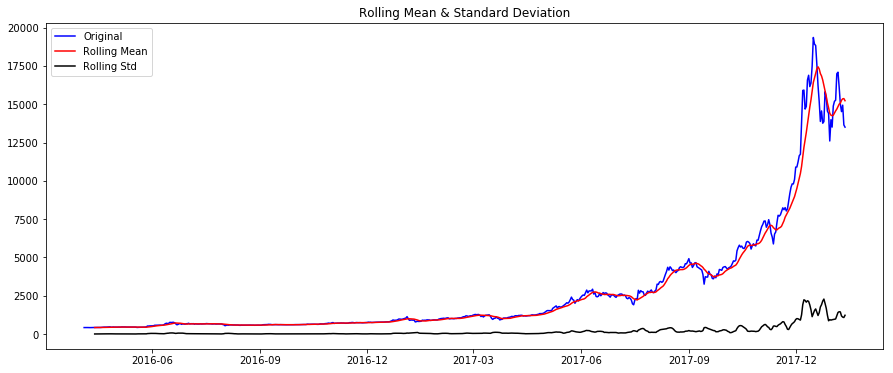

Results of Dickey-Fuller Test:
Test Statistic                   0.016039
p-value                          0.959839
#Lags Used                      20.000000
Number of Observations Used    628.000000
Critical Value (1%)             -3.440806
Critical Value (5%)             -2.866153
Critical Value (10%)            -2.569227
dtype: float64


In [200]:
test_stationarity(reg_data['Close'])

In [201]:
#Conclusion: We can easily see that the time series is not stationary, and 
# our test_stationarity function confirms what we see.
# refer: https://machinelearningmastery.com/time-series-data-stationary-python/

#Results of Dickey-Fuller Test:
#Test Statistic                   -1.943407
#p-value                           0.311925
#Lags Used                       23.000000
#Next Step would be to make TS stationary


In [202]:
reg_data.dropna(inplace=True)

In [203]:
moving_avg = reg_data['Close'].rolling(window=10).mean()

In [204]:
moving_avg.dropna(inplace=True)
#print(moving_avg)

In [205]:
ts_log = np.log(reg_data['Close'])

In [206]:
ts_log.dropna(inplace=True)
#print(ts_log)

In [207]:
ts_log_moving_avg_diff = ts_log - moving_avg

In [208]:
ts_log_moving_avg_diff.dropna(inplace=True)
#print(ts_log_moving_avg_diff)


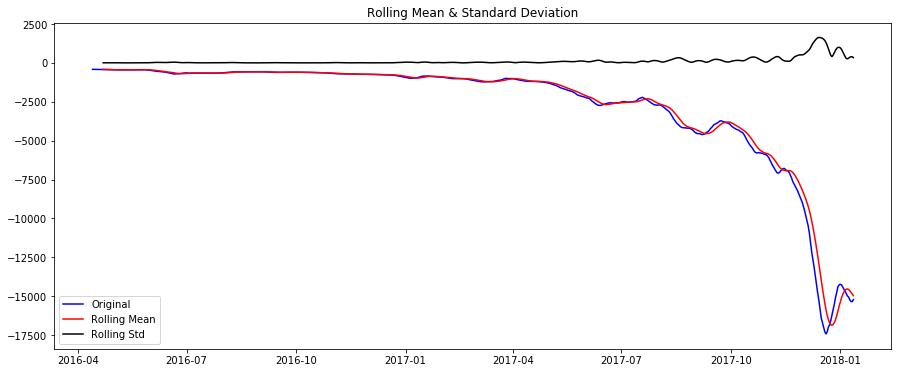

Results of Dickey-Fuller Test:
Test Statistic                   2.379472
p-value                          0.999000
#Lags Used                      19.000000
Number of Observations Used    620.000000
Critical Value (1%)             -3.440941
Critical Value (5%)             -2.866213
Critical Value (10%)            -2.569259
dtype: float64


In [209]:
test_stationarity(ts_log_moving_avg_diff) 

C:\Users\kundami\Anaconda3\envs\PythonData\lib\site-packages\ipykernel\__main__.py:1: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()



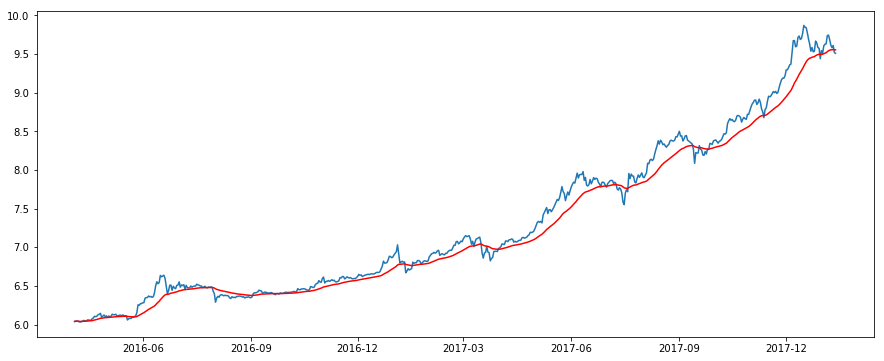

In [210]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

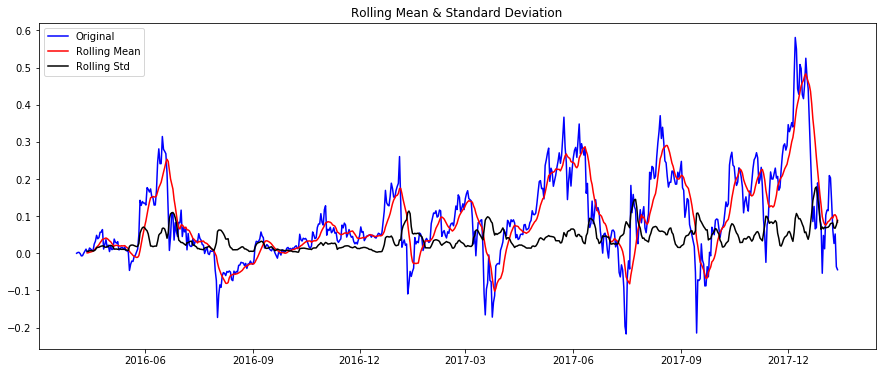

Results of Dickey-Fuller Test:
Test Statistic                  -4.286946
p-value                          0.000468
#Lags Used                       0.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In [211]:
expwighted_avg.dropna(inplace=True)
ts_log_ewma_diff = ts_log - expwighted_avg

test_stationarity(ts_log_ewma_diff)

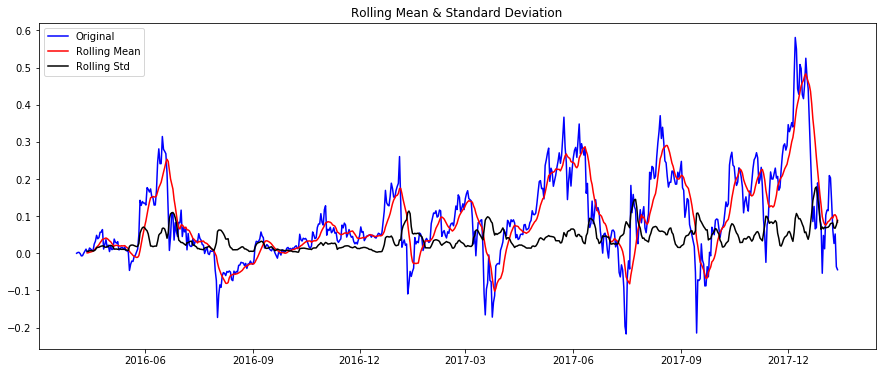

Results of Dickey-Fuller Test:
Test Statistic                  -4.286946
p-value                          0.000468
#Lags Used                       0.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In [212]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

In [213]:
#Since we have Trend we need to eliminate it.

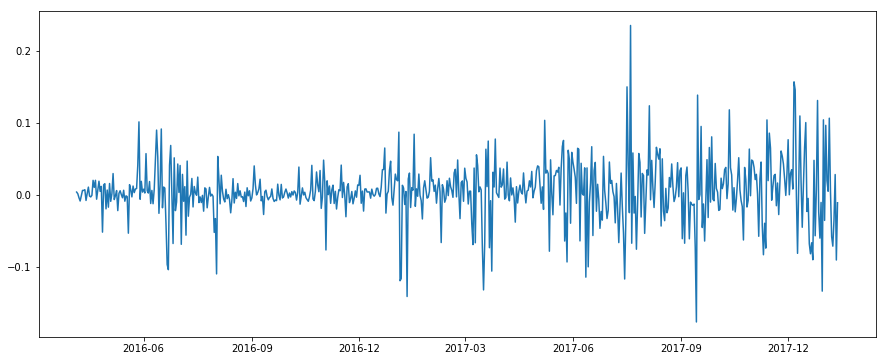

In [214]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

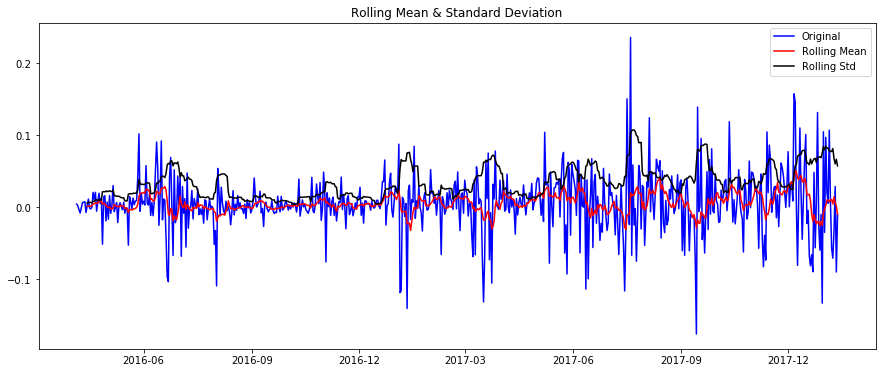

Results of Dickey-Fuller Test:
Test Statistic                 -24.857668
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    647.000000
Critical Value (1%)             -3.440498
Critical Value (5%)             -2.866017
Critical Value (10%)            -2.569154
dtype: float64


In [215]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [216]:
#Trend is removed..
#Results of Dickey-Fuller Test:
#Test Statistic                -6.602168e+00
#p-value                        6.693455e-09

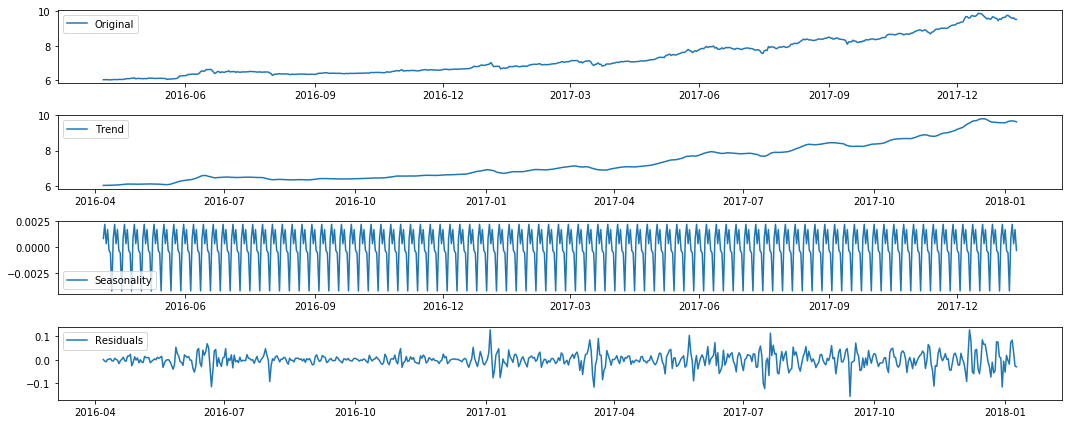

In [217]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


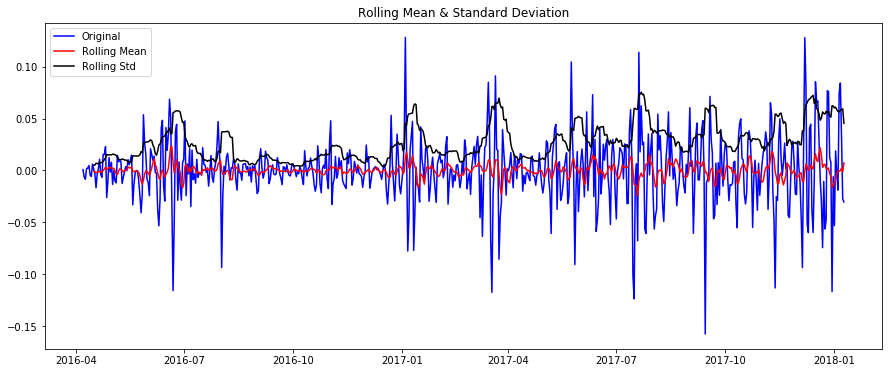

Results of Dickey-Fuller Test:
Test Statistic                -1.077290e+01
p-value                        2.359422e-19
#Lags Used                     1.600000e+01
Number of Observations Used    6.260000e+02
Critical Value (1%)           -3.440839e+00
Critical Value (5%)           -2.866168e+00
Critical Value (10%)          -2.569235e+00
dtype: float64


In [218]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [219]:
#Now do forecasting

In [220]:
from statsmodels.tsa.arima_model import ARIMA

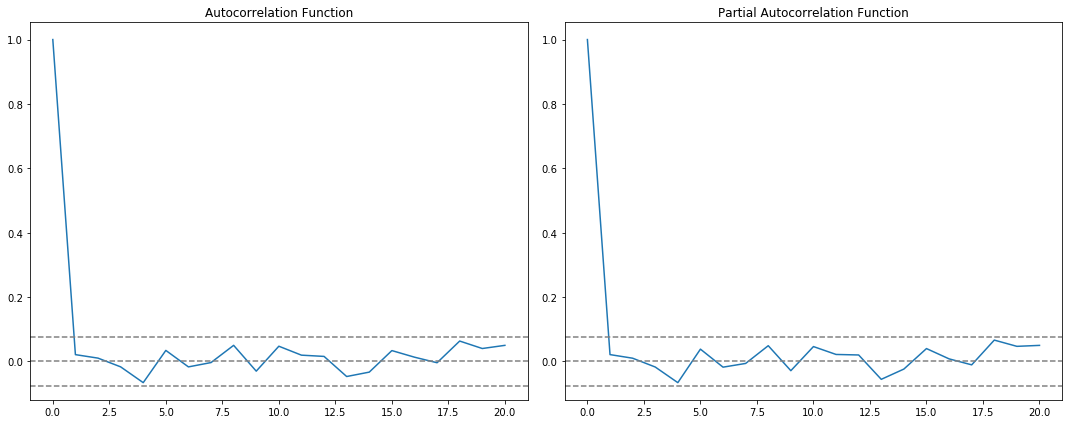

In [221]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

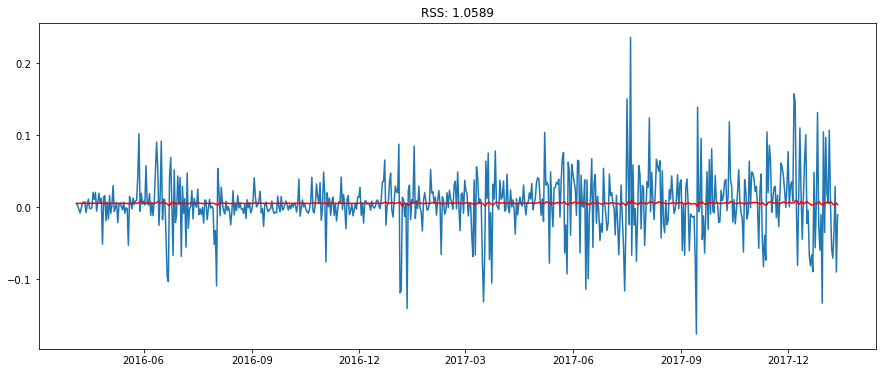

In [222]:
#MA model:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

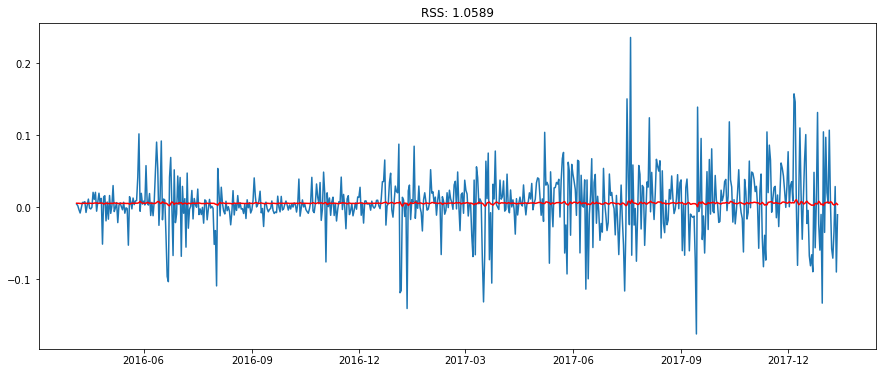

In [223]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

C:\Users\kundami\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



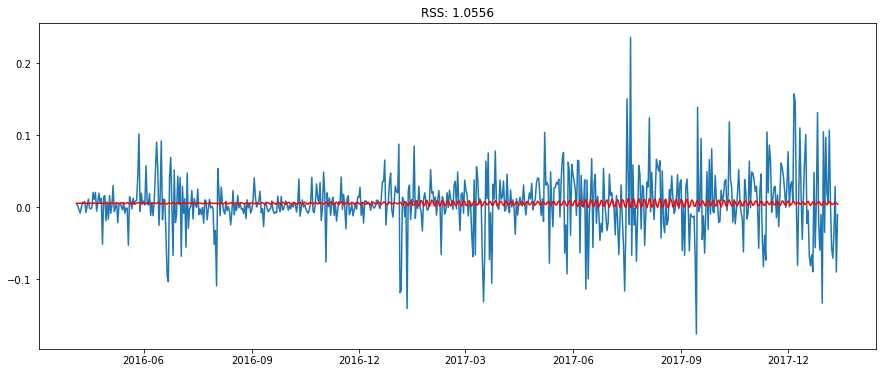

In [224]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [225]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2016-04-05    0.005349
2016-04-06    0.005343
2016-04-07    0.005327
2016-04-08    0.005294
2016-04-09    0.005264
dtype: float64


In [226]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Date
2016-04-05    0.005349
2016-04-06    0.010692
2016-04-07    0.016019
2016-04-08    0.021313
2016-04-09    0.026577
dtype: float64


In [227]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\kundami\Anaconda3\envs\PythonData\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Date
2016-04-04    6.042609
2016-04-05    6.047958
2016-04-06    6.053301
2016-04-07    6.058628
2016-04-08    6.063922
dtype: float64

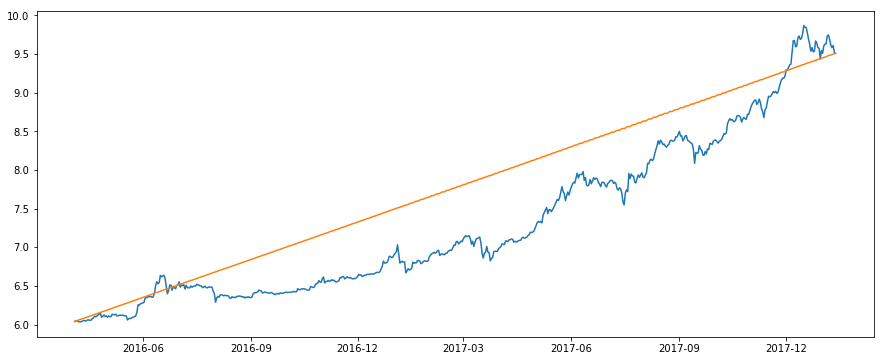

In [228]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

In [229]:
reg_data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2016-04-04,421.48,421.600,417.542,420.990,582.497009,244552.127940,419.834135
2016-04-05,419.51,424.970,419.500,422.760,985.017478,416690.188335,423.028218
2016-04-06,423.00,424.611,421.560,423.550,891.882500,377349.566170,423.093363
2016-04-07,423.54,424.390,420.060,422.010,1047.522184,442740.665589,422.655169
2016-04-08,422.27,425.960,418.000,418.551,860.574531,364333.296967,423.360539


In [230]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
#df_scatter(reg_data, 'Bitcoin Price (USD) By Exchange')
#df_scatter(predictions_ARIMA, 'Bitcoin Price (USD) By Exchange')

trace1 = go.Scatter(
    x=reg_data.index,
    y=reg_data['Close'],
    name='Actual Close'
)
trace2 = go.Scatter(
    x=reg_data.index,
    y=predictions_ARIMA,
    name='Predicted Close'
)
data = [trace1, trace2]
layout = go.Layout(
    title='Actual Vs Predicted using ARIMA',
    yaxis=dict(
        title='Closing Price'
    ),
    yaxis2=dict(
        title='yaxis2 title',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
fig = go.Figure(data=data, layout=layout)
#plot_url = py.plot(fig)
py.iplot(fig)

In [261]:
reg_data['y'] = np.log(reg_data['Close'])
reg_data['ds'] = reg_data.index
fb_reg_data = reg_data.loc[:,['ds','y']]
fb_reg_data = fb_reg_data.reset_index(drop=True)
fb_reg_data.dropna(inplace=True)
fb_reg_data.head()

,ds,y
0,2016-04-04,6.042609
1,2016-04-05,6.046805
2,2016-04-06,6.048672
3,2016-04-07,6.045029
4,2016-04-08,6.036799


In [262]:
from fbprophet import Prophet
import seaborn as sns
import matplotlib.dates as mdates

In [287]:
def plot_data(df,X,future,columns,title):
    future = future['ds'].apply(lambda x: mdates.date2num(x))
    fig, ax = plt.subplots(figsize=(12, 8))
    #plot the mean predicted value
    sns.tsplot(df[columns[0]], time=future, alpha=0.8, color="red", ax=ax)
    #plot the actual value
    plt.scatter(future, X,color="green", alpha=0.3)
    #set the major axis as the date
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
    #configure the plot
    fig.autofmt_xdate()
    #plot the upper and lower bounded regions and fill it
    plt.plot_date(future,df[columns[1]],'-',color="#66b3ff")
    plt.plot_date(future, df[columns[2]],'-',color="#004080")
    plt.fill_between(future, df[columns[1]], df[columns[2]],facecolor='blue', alpha=0.1, interpolate=True)
    # Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price in USD', fontsize=12)
    plt.title(title, fontsize=15)
    plt.show()

In [288]:

m = Prophet()
m.fit(fb_reg_data)
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)
predicted  = forecast[['yhat', 'yhat_lower', 'yhat_upper']].applymap(np.exp)

   

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [289]:
future.tail()

,ds
644,2018-01-08
645,2018-01-09
646,2018-01-10
647,2018-01-11
648,2018-01-12


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


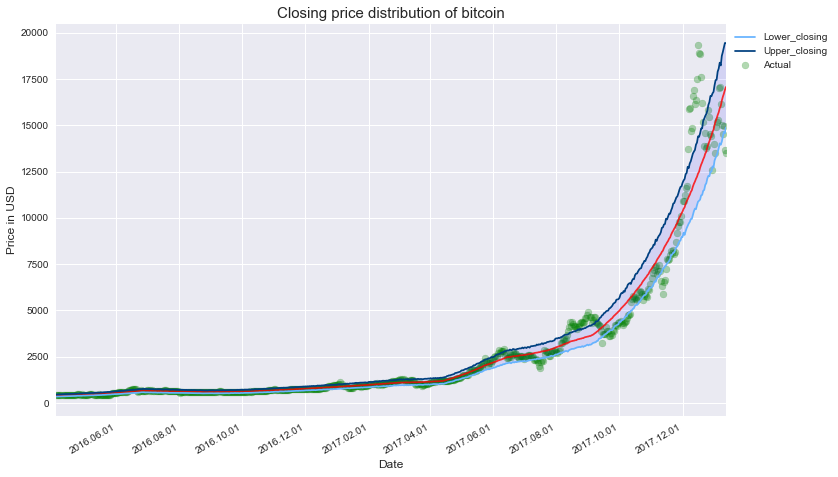

In [290]:
##https://facebook.github.io/prophet/docs/quick_start.html

m = Prophet()
m.fit(fb_reg_data)
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)
predicted  = forecast[['yhat', 'yhat_lower', 'yhat_upper']].applymap(np.exp)
cols = ["Mean", "Lower_closing", "Upper_closing"]
predicted.columns = cols
actual = np.exp(fb_reg_data["y"])
#actual = actual[::-1]
actual.name = "Actual"
title = "Closing price distribution of bitcoin"
plot_data(predicted, actual, future, cols,title)


In [295]:
predicted = forecast[['yhat_lower', 'yhat_upper']].applymap(np.exp)
acc = 1
err = 1
for x, y in zip(predicted[['yhat_lower', 'yhat_upper']].values,actual):
    if x[0] <= y and  y <= x[1]:
        acc+=1
    else :
        err+=1
print(acc/len(actual))
print(err/len(actual))


0.8181818181818182
0.18489984591679506
